# Polynomial fitting with confidence/prediction intervals

> Marcos Duarte  
> [Laboratory of Biomechanics and Motor Control](https://bmclab.pesquisa.ufabc.edu.br/)  
> Federal University of ABC, Brazil

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, r'./../functions')

Let's implement the polynomial fit by least squares and calculate the confidence and prediction intervals assuming normal distribution of the residuals.  
The code of the `polyfit.py` function is at the end of this notebook (or download the function from the GitHub repo).

In [2]:
from polyfit import polyfit

In [3]:
help(polyfit)

Help on function polyfit in module polyfit:

polyfit(x, y, degree, yerr=None, plot=True, xlabel='x', ylabel='y', title=True, legend=True, plotCI=True, plotPI=True, axis=None)
    Least squares polynomial regression of order degree for x vs. y [1]_
    
    Parameters
    ----------
    x : numpy array_like, shape (N,)
        Independent variable, x-coordinates of the N points (x[i], y[i]).
    y : numpy array_like, shape (N,)
        Dependent variable, y-coordinates of the N points (x[i], y[i]).
    degree : integer
        Degree of the polynomial to be fitted to the data.
    yerr : numpy array_like, shape (N,), optional (default = None)
        Error (uncertainty) in y. If no error is entered, unitary equal errors
        for all y values are assumed.
    plot : bool, optional (default = True)
        Show plot (True) of not (False). 
    xlabel : string, optional (default = 'x')
        Label for the x (horizontal) axis.
    ylabel : string, optional (default = 'y')
        Label

Some data to play:

In [4]:
N = 50
x = np.linspace(-2, 4, N)
y = np.polyval([3, 1, 2], x) + np.random.randn(N)*8

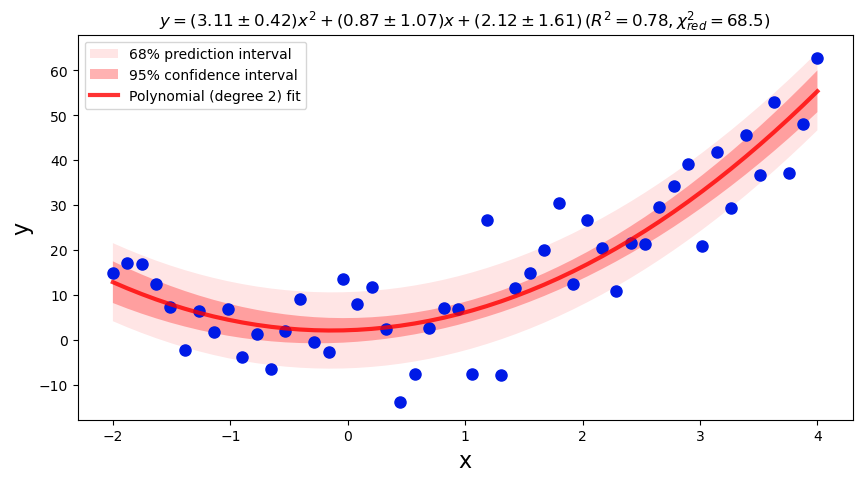

In [5]:
p, perr, R2, chi2red, yfit, ci, pi, MSE = polyfit(x, y, 2)

In [6]:
p

array([3.10831691, 0.86552217, 2.11660502])

In [7]:
MSE

64.40087353553028

The $\chi^2_{red}$ value is much higher than one, suggesting a poor fitting (although the $R^2$ value is good). We can see that the data variability not accounted by the model is very high. One way of considering this variability is to treat it as error (uncertainty) in the measurement of the y variable. The square root of the $\chi^2_{red}$ value is a good average estimate of this error in y (see for example page 79 of [https://www.astro.rug.nl/software/kapteyn/_downloads/statmain.pdf](https://www.astro.rug.nl/software/kapteyn/_downloads/statmain.pdf)).  
Let's generate an array for the error in y:

In [8]:
yerr = np.ones(N)*np.sqrt(chi2red)
print('Average uncertainty in y:', yerr[0])

Average uncertainty in y: 8.27717147285168


And let's run the fitting again:

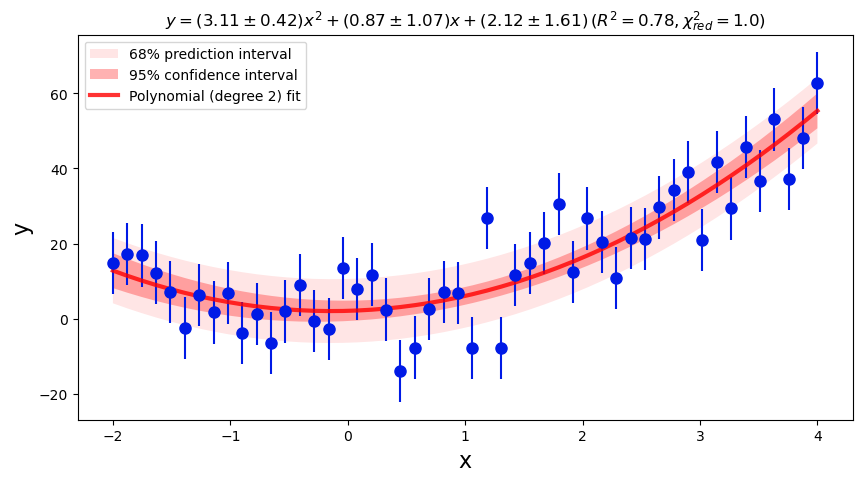

In [9]:
p, perr, R2, chi2red, yfit, ci, pi, MSE = polyfit(x, y, 2, yerr=yerr)

Let's see the results of linear and quadratic fits:

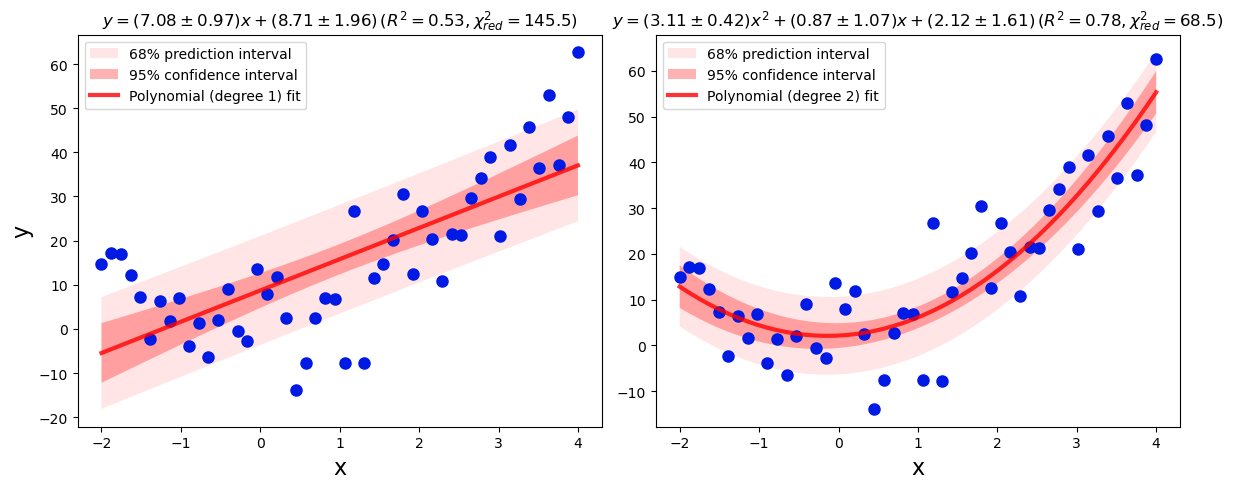

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
p, perr, R2, chi2red, yfit, ci, pi, MSE = polyfit(x, y, degree=1, axis=ax[0])
p, perr, R2, chi2red, yfit, ci, pi, MSE = polyfit(x, y, degree=2, axis=ax[1], ylabel='')
plt.tight_layout()

## P.S.: Calculation of moving standard-deviation

Let's calculate the moving standard-deviation just to compare with the 68% (1 SD) prediction interval for the fitted polynomial given in the plot above.

In [11]:
import pandas as pd

ys = pd.Series(y)
# use a moving window of one-tenth of the size of the data.
ys_std = ys.rolling(window=int(np.round(N/10)), min_periods=4, center=True).std()

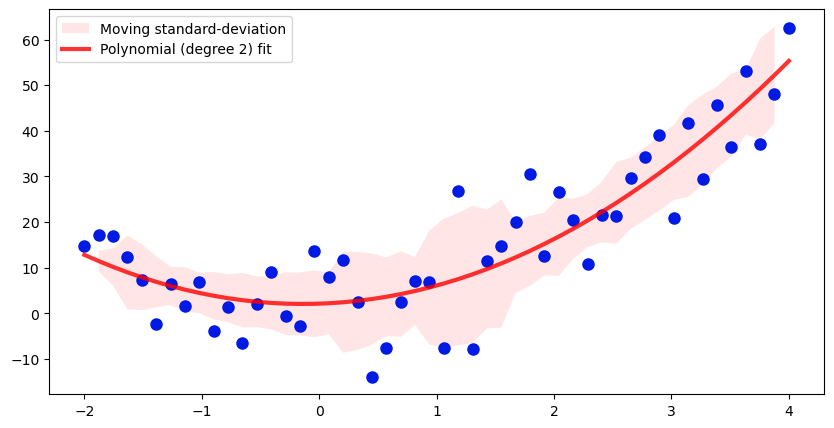

In [12]:
plt.figure(figsize=(10, 5))
plt.fill_between(x, yfit+ys_std, yfit-ys_std, color=[1, 0, 0, 0.1], edgecolor=None,
                 label='Moving standard-deviation')
plt.plot(x, y, 'o', color=[0, 0.1, .9, 1], markersize=8)
plt.plot(x, yfit, linewidth=3, color=[1, 0, 0, .8], label='Polynomial (degree {}) fit'.format(2))
plt.legend()
plt.show()

## Function `polyfit.py`

In [13]:
# %load ./../functions/polyfit.py
"""Least squares polynomial regression with confidence/prediction intervals.
"""

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = 'polyfit.py v.1.0.3 20123/07/07'
__license__ = "MIT"

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def polyfit(x, y, degree, yerr=None, plot=True, xlabel='x', ylabel='y',
            title=True, legend=True, plotCI=True, plotPI=True, axis=None):
    """Least squares polynomial regression of order degree for x vs. y [1]_

    Parameters
    ----------
    x : numpy array_like, shape (N,)
        Independent variable, x-coordinates of the N points (x[i], y[i]).
    y : numpy array_like, shape (N,)
        Dependent variable, y-coordinates of the N points (x[i], y[i]).
    degree : integer
        Degree of the polynomial to be fitted to the data.
    yerr : numpy array_like, shape (N,), optional (default = None)
        Error (uncertainty) in y. If no error is entered, unitary equal errors
        for all y values are assumed.
    plot : bool, optional (default = True)
        Show plot (True) of not (False). 
    xlabel : string, optional (default = 'x')
        Label for the x (horizontal) axis.
    ylabel : string, optional (default = 'y')
        Label for the y (vertical) axis.
    title : bool, optional (default = True)
        Show title (True) of not (False) in the plot.
    legend : bool, optional (default = True)
        Show legend (True) of not (False) in the plot.
    plotCI : bool, optional (default = True)
        Plot the shaded area for the confidence interval (True) of not (False).
    plotPI : bool, optional (default = True)
        Plot the shaded area for the prediction interval (True) of not (False).
    axis : matplotlib object, optional (default = None)
        Matplotlib axis object where to plot.

    Returns
    -------
    p : numpy array, shape (deg + 1,)
        Coefficients of the least squares polynomial fit.
    perr : numpy array, shape (deg + 1,)
        Standard-deviation of the coefficients.
    R2 : float
        Coefficient of determination.
    chi2red : float
        Reduced chi-squared
    yfit : numpy array, shape (N + 1,)
        Values of the fitted polynomial evaluated at x.
    ci : numpy array, shape (N + 1,)
        Values of the 95% confidence interval evaluated at x.
    pi : numpy array, shape (N + 1,)
        Values of the 68% prediction interval evaluated at x.
    MSE : float
        Mean squared error of the regression.

    References
    ----------
    .. [1] https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html


    Examples
    --------
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> N = 50
    >>> x = np.linspace(-2, 4, N)
    >>> y = np.polyval([3, 1, 2], x) + np.random.randn(N)*8
    >>> # simple use:
    >>> polyfit(x, y, 2);
    >>> # compare two models:
    >>> fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    >>> p1, perr1, R21, chi2red1, yfit1, ci1, pi1, MSE = polyfit(x, y, 1, axis=ax[0])
    >>> p2, perr2, R22, chi2red2, yfit2, ci2, pi2, MSE = polyfit(x, y, 2, axis=ax[1])
    >>> plt.tight_layout()
    >>> Enter error (uncertainty) in y:
    >>> yerr = np.ones(N)*8
    >>> polyfit(x, y, 2, yerr);


    Version history
    ---------------
    '1.0.3':
        Correct the order of the terms in title and account for zeros in yerr.
    '1.0.2':
        Included output 'MSE', mean squared error of the regression.

    """

    x, y = np.asarray(x), np.asarray(y)
    N = y.size
    if yerr is None:
        yerr = np.ones(N)
        errorbar = False
    else:
       # replace zeros in yerr (because in the fit, weigths = 1/yerr)
       yerr[np.where(yerr == 0)] = 10 * np.finfo(np.float32).eps
       errorbar = True
    # coefficients and covariance matrix of the least squares polynomial fit
    p, cov = np.polyfit(x, y, degree, w=1/yerr, cov=True)
    # evaluate the polynomial at x
    yfit = np.polyval(p, x)
    # standard-deviation of the coefficients
    perr = np.sqrt(np.diag(cov))
    # residuals
    res = y - yfit
    # reduced chi-squared, see for example page 79 of
    # https://www.astro.rug.nl/software/kapteyn/_downloads/statmain.pdf
    chi2red = np.sum(res**2/yerr**2)/(N - degree - 1)
    # standard deviation of the error (residuals)
    s_err = np.sqrt(np.sum(res**2)/(N - degree - 1))
    # sum of squared residuals
    SSres = np.sum(res**2)
    # mean squared error
    MSE = SSres/N
    # sum of squared totals
    SStot = np.sum((y - np.mean(y))**2)
    # coefficient of determination
    R2 = 1 - SSres/SStot
    # adjusted coefficient of determination
    R2adj = 1 - (SSres/(N - degree - 1)) / (SStot/(N - 1))
    # 95% (2 SD) confidence interval for the fit
    t95 = stats.t.ppf(0.95 + (1-0.95)/2, N - degree - 1)
    ci = t95 * s_err * np.sqrt(    1/N + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # 68% (1 SD) prediction interval for the fit
    t68 = stats.t.ppf(0.683 + (1-0.683)/2, N - degree - 1)
    pi = t68 * s_err * np.sqrt(1 + 1/N + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # plot
    if plot:
        # generate values if number of input values is too small or too large
        if N < 50 or N > 500:
            x2 = np.linspace(np.min(x), np.max(x), 100)
            yfit2 = np.polyval(p, x2)
            ci2 = np.interp(x2, x, ci)
            pi2 = np.interp(x2, x, pi)
        else:
            x2, yfit2, ci2, pi2 = x, yfit, ci, pi

        if axis is None:
            fig, axis = plt.subplots(1, 1, figsize=(10, 5))
        else:
            fig = 0
        if plotPI:
            axis.fill_between(x2, yfit2+pi2, yfit2-pi2, color=[1, 0, 0, 0.1],
                              edgecolor=None, label='68% prediction interval')
        if plotCI:
            axis.fill_between(x2, yfit2+ci2, yfit2-ci2, color=[1, 0, 0, 0.3],
                              edgecolor=None, label='95% confidence interval')
        if errorbar:
            axis.errorbar(x, y, yerr=yerr, fmt='o', capsize=0,
                          color=[0, 0.1, .9, 1], markersize=8)
        else:
            axis.plot(x, y, 'o', color=[0, 0.1, .9, 1], markersize=8)
        axis.plot(x2, yfit2, linewidth=3, color=[1, 0, 0, .8],
                 label='Polynomial (degree {}) fit'.format(degree))
        axis.set_xlabel(xlabel, fontsize=16)
        axis.set_ylabel(ylabel, fontsize=16)
        if legend:
            axis.legend()
        if title:
            xs = ['x^{:d}'.format(ideg) for ideg in range(2, degree+1)] + ['x', '']
            title = ['({:.2f} \pm {:.2f}) {}'.format(i, j, k) for i, j, k in zip(p, perr, xs)]
            R2str = '\, (R^2 = ' + '{:.2f}'.format(R2) + \
                    ', \chi^2_{red} = ' + '{:.1f}'.format(chi2red) + ')'
            title = '$ y = ' + '+'.join(title) + R2str + '$'
            axis.set_title(title, fontsize=12, color=[0, 0, 0])
        if fig:
            plt.show()

    return p, perr, R2, chi2red, yfit, ci, pi, MSE